In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, ReLU, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

%matplotlib inline

In [40]:
# load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [41]:
train_df.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
test_df.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Convert data to numpy arrays
img_rows, img_cols = 28, 28
num_classes = train_df['label'].nunique()

# Split train + val data
X = train_df.drop(columns=['label']).values
y = train_df['label'].values

# one-hot encode the labels
y = keras.utils.to_categorical(y, num_classes)

if K.image_data_format() == 'channels_first':
    X = X.reshape(-1, 1, img_rows, img_cols)
    X_test = test_df.values.reshape(-1, 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X = X.reshape(-1, img_rows, img_cols, 1)
    X_test = test_df.values.reshape(-1, img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [44]:
# normalize data
X = X.astype('float32')
X_test = X_test.astype('float32')
X /= 255
X_test /= 255

In [45]:
# Split train + val data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [46]:
# train array shape
X_train.shape, y_train.shape

((28140, 28, 28, 1), (28140, 10))

In [47]:
# val array shape
X_val.shape, y_val.shape

((13860, 28, 28, 1), (13860, 10))

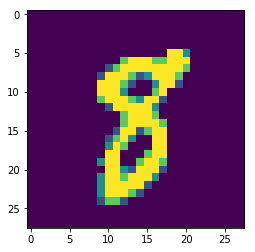

In [48]:
# plot first image to check if it is in the correct format
plt.imshow(X_train[0,:,:, 0])

In [49]:
# create model
def get_model():
    model = Sequential()
    model.add(Conv2D(filters=32, 
                     kernel_size=(3,3),
                     activation="relu",
                     input_shape=input_shape))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3),
                     activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, 
                     kernel_size=(3,3),
                     activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

In [50]:
# Model summary
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
__________

In [51]:
# Setup train data transformer
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

train_datagen.fit(X_train)

In [52]:
# Setup validation data transformer
val_datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 horizontal_flip=False)

val_datagen.fit(X_train)

In [53]:
batch_size = 128
epochs = 10
model_gen = get_model()
model_gen.fit_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    shuffle=True,
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=batch_size),
                    validation_steps=len(X_val) / batch_size,
                    verbose=1)

Epoch 1/10
220/219 [==============================] - 89s 405ms/step - loss: 1.2205 - acc: 0.5704 - val_loss: 0.3468 - val_acc: 0.8898
Epoch 2/10
220/219 [==============================] - 97s 442ms/step - loss: 0.5769 - acc: 0.8096 - val_loss: 0.1883 - val_acc: 0.9426
Epoch 3/10
220/219 [==============================] - 88s 400ms/step - loss: 0.4190 - acc: 0.8655 - val_loss: 0.1466 - val_acc: 0.9542
Epoch 4/10
220/219 [==============================] - 98s 443ms/step - loss: 0.3380 - acc: 0.8945 - val_loss: 0.1110 - val_acc: 0.9655
Epoch 5/10
220/219 [==============================] - 97s 440ms/step - loss: 0.2889 - acc: 0.9113 - val_loss: 0.1315 - val_acc: 0.9595
Epoch 6/10
220/219 [==============================] - 99s 452ms/step - loss: 0.2588 - acc: 0.9198 - val_loss: 0.1108 - val_acc: 0.9652
Epoch 7/10
220/219 [==============================] - 95s 434ms/step - loss: 0.2430 - acc: 0.9252 - val_loss: 0.0798 - val_acc: 0.9752
Epoch 8/10
220/219 [==============================] - 9

In [62]:
score = model_gen.evaluate_generator(val_datagen.flow(X_val, y_val, batch_size=batch_size), 
                                     steps=len(X_val) / batch_size,
                                     verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

109/108 [==============================] - 8s 74ms/step
Test loss: 0.06943384749548775
Test accuracy: 0.9781385280697205


In [55]:
batch_size = 128
epochs = 10
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 28140 samples, validate on 13860 samples
Epoch 1/10
28140/28140 [==============================] - 96s 3ms/step - loss: 0.3474 - acc: 0.8908 - val_loss: 0.0738 - val_acc: 0.9776
Epoch 2/10
28140/28140 [==============================] - 92s 3ms/step - loss: 0.1053 - acc: 0.9687 - val_loss: 0.0515 - val_acc: 0.9838
Epoch 3/10
28140/28140 [==============================] - 94s 3ms/step - loss: 0.0763 - acc: 0.9769 - val_loss: 0.0438 - val_acc: 0.9854
Epoch 4/10
28140/28140 [==============================] - 93s 3ms/step - loss: 0.0623 - acc: 0.9813 - val_loss: 0.0413 - val_acc: 0.9874
Epoch 5/10
28140/28140 [==============================] - 93s 3ms/step - loss: 0.0513 - acc: 0.9857 - val_loss: 0.0342 - val_acc: 0.9891
Epoch 6/10
28140/28140 [==============================] - 91s 3ms/step - loss: 0.0467 - acc: 0.9856 - val_loss: 0.0303 - val_acc: 0.9903
Epoch 7/10
28140/28140 [==============================] - 93s 3ms/step - loss: 0.0397 - acc: 0.9882 - val_loss: 0.0320 - val_acc

In [56]:
score = model.evaluate(X_val, y_val, batch_size=256, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

13860/13860 [==============================] - 11s 810us/step
Test loss: 0.031108998779266598
Test accuracy: 0.9907647907303869


In [63]:
# train model on the full train data
batch_size = 128
epochs = 10
model_final = get_model()
model_final.fit(X, y,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1)

Epoch 1/10
42000/42000 [==============================] - 111s 3ms/step - loss: 0.2927 - acc: 0.9086
Epoch 2/10
42000/42000 [==============================] - 122s 3ms/step - loss: 0.0909 - acc: 0.9726
Epoch 3/10
42000/42000 [==============================] - 119s 3ms/step - loss: 0.0647 - acc: 0.9797
Epoch 4/10
42000/42000 [==============================] - 121s 3ms/step - loss: 0.0507 - acc: 0.9853
Epoch 5/10
42000/42000 [==============================] - 121s 3ms/step - loss: 0.0455 - acc: 0.9857
Epoch 6/10
42000/42000 [==============================] - 122s 3ms/step - loss: 0.0370 - acc: 0.9887
Epoch 7/10
42000/42000 [==============================] - 122s 3ms/step - loss: 0.0356 - acc: 0.9888
Epoch 8/10
42000/42000 [==============================] - 122s 3ms/step - loss: 0.0305 - acc: 0.9906
Epoch 9/10
42000/42000 [==============================] - 121s 3ms/step - loss: 0.0268 - acc: 0.9917
Epoch 10/10
42000/42000 [==============================] - 125s 3ms/step - loss: 0.0248 - a

In [64]:
# create submission predictions
predictions = model_final.predict(X_test, batch_size=256, verbose=1)

28000/28000 [==============================] - 25s 879us/step


In [66]:
# save predictions
out_df = pd.DataFrame({"ImageId": list(range(1, len(predictions) + 1)),
                       "Label": np.argmax(predictions, axis=1)})
out_df.to_csv('keras_submission.csv', index=False)